The purpose of this notebook is to cluster the data. I decided on using KModes to cluster which looks at the mode (most frequently occuring value) and
the dissimilarity of the data. The lesser the dissimlarities, the more similar the data is to each other. KModes is specifically designed to be used 
on categorical and binary data which sets it apart from other clustering algorithms like KMeans which assume that the data is continous and calculates
the euclidean distance between points. Another potential clustering algorithm that could be used is HDBScan or DBScan, however, a significant amount of 
tuning would be necessary to get accurate results. 

In [2]:
import pandas as pd
from kmodes.kmodes import KModes
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle

In [3]:
df = pd.read_csv("../data/processed_data.csv")

In [4]:
def val_count(data):
    counter = 0
    for i in data.columns[0:3]: #don't slice to see the full data
        print(counter)
        print(data[i].value_counts())
        counter += 1
        print("=========================="*5)
    print(data.shape)

In [5]:
# val_count(df)

Use this cell to find optimal k values (clusters) for KMODES with an elbow curve. Look for the elbow, where the graph sharply bends. 
Cost is a measure of how well the clustering fits the data. A lower costs means that the data is closer to the centroid, indicating 
a better fit, while a higher cost is a worse fit because the data is farther from the clusters. Optimal K values is 6.

(46852, 107)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 131936.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 131936.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 131936.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 131936.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 234, cost: 105702.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3244, cost: 99968.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7611, cost: 114888.0
Init: initializing centroids
Init: initializing 

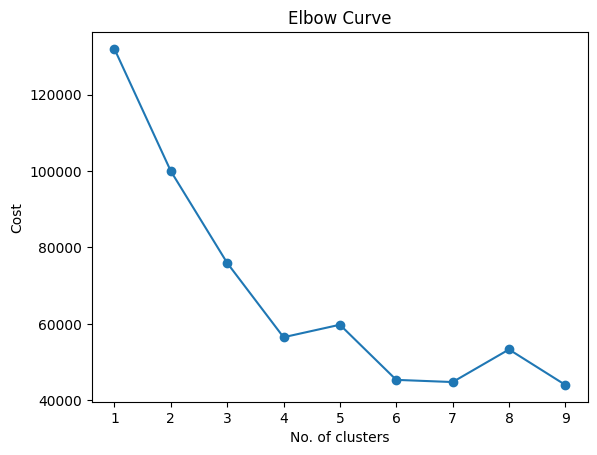

In [30]:
print(df.shape)
cost = []
K = range(1,10)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "Huang", n_init = 4, verbose=1) #using init = huang because the initialization is random and is computationally faster while achieving the same/better clustering results than Cao
    kmode.fit_predict(df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'o-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

Use this cell to find optimal k value for KMODES with a Silhouette Score curve. More accurate than elbow graph, but significatly more time consuming.
A Sillhouette score is a measure of how well a data point fits within the assigned cluster, a higher score means that the data is closely clustered together, a score near 0 indicates that points overlap or on the boundaries of other clusters, and a negative score indicates that points are in completely wrong clusters. To read the graph, choose the cluster with the highest Sillhouette score while also balancing the lowest number of clusters. Optimal K values is 6. Using either elbow graph or sillhouette score will work fine.

(46852, 107)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7775, cost: 105702.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2447, cost: 98491.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 13158, cost: 99968.0
Run 3, iteration: 2/100, moves: 217, cost: 99968.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2891, cost: 99968.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 75952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 19400, cost: 88973.0
Run 2, iteration: 2/100, moves: 1183, cost: 79765.0
Run 2, iteration: 3/100, moves: 8797, cost: 76624.0
Run 2, iteration: 

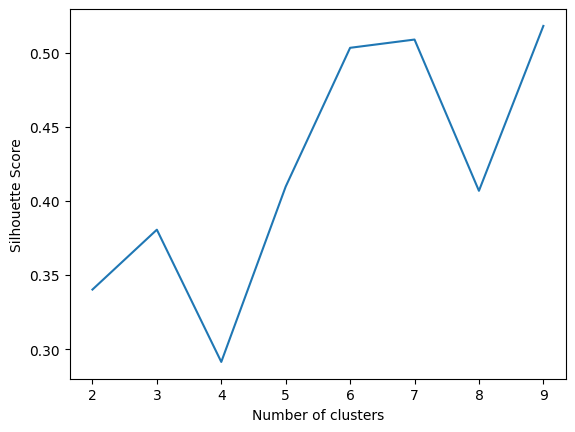

In [31]:
print(df.shape)
results = {}
K = range(2,10)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "Huang", n_init = 4, verbose=1) #Make sure to change the n_init argument as needed to speedup compile time
    clusters = kmode.fit_predict(df)
    db_index = silhouette_score(df, clusters, metric= "hamming") #MUST use hamming metric because data is binary
    results[k] = db_index
    

plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [6]:
# clusters the data. Use the k amount of clusters found in either the elbow curve or Sillhouette Score curve for n_clusters.
km = KModes(n_clusters= 6, init = "Huang" , n_init= 20).fit(df)
df["cluster"] = km.labels_

# val_count(df)


Sillhouette score is to measure how well the clustering went. Any score of 0.5 or higher is generally good and indicates that the data is more closely associated with its own cluster than other clusters. Scores close to 1 indicate clear seperations, scores near 0 mean clustering is more uncertain, and scores near -1 indicate that there has likely been misclassifcation. For this measurement, it is necessary to use the Hamming metric as the data that is used is now binary. The Hamming Metric takes a look at the dissimilarity in the data, which is necessary because the binary data prevents the use of the tradictional Euclidean distance metric.

In [7]:
print(f"Silhouette Score: {silhouette_score(df.drop(columns= "cluster"), df["cluster"], metric= "hamming")}")


Silhouette Score: 0.5227960942417903


In [8]:
df.to_csv("../data/clustered_data.csv", index= False)

In [9]:
with open('../models/kmodes_model.pkl', 'wb') as f:
    pickle.dump(km, f)
